# **A1**: Band-gap prediction using Autoencoders with ACSF descriptors

In [1]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests
from io import StringIO
warnings.filterwarnings('ignore')
import gc
import joblib

#!pip install pymatgen
#!pip install rdkit
!pip install dscribe

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from dscribe.descriptors import ACSF
from ase import Atoms
from ase.io import read

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.4/777.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 27.9 MB/s eta 0:00:00


## **Step 1: Load dataset**

In [3]:
# Unzip the train dataset
!unzip train_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_dataset/MOF_08553.cif  
  inflating: train_dataset/MOF_15663.cif  
  inflating: train_dataset/MOF_15660.cif  
  inflating: train_dataset/MOF_11025.cif  
  inflating: train_dataset/MOF_11073.cif  
  inflating: train_dataset/MOF_15377.cif  
  inflating: train_dataset/MOF_02026.cif  
  inflating: train_dataset/MOF_14308.cif  
  inflating: train_dataset/MOF_09865.cif  
  inflating: train_dataset/MOF_13603.cif  
  inflating: train_dataset/MOF_10347.cif  
  inflating: train_dataset/MOF_13872.cif  
  inflating: train_dataset/MOF_06673.cif  
  inflating: train_dataset/MOF_09732.cif  
  inflating: train_dataset/MOF_19729.cif  
  inflating: train_dataset/MOF_08630.cif  
  inflating: train_dataset/MOF_09711.cif  
  inflating: train_dataset/MOF_08422.cif  
  inflating: train_dataset/MOF_18297.cif  
  inflating: train_dataset/MOF_15067.cif  
  inflating: train_dataset/MOF_08889.cif  
  inflating: train_dataset/MOF_01419.cif  
  i

In [7]:
# Read the master CSV file with file name and energy
master_df = pd.read_csv('train_dataset/train.csv')
master_df.columns = ['cif_files','formula','pld','lcd','density','energy','band_gap']
len(master_df)

16297

In [89]:
master_df["ID_num"] = master_df["cif_files"].str.extract(r"MOF_(\d+)").astype(int)
master_df = master_df.sort_values(by="ID_num").reset_index(drop=True)

# Defining features (X) and target (y) based on your plots
features = ['energy', 'pld', 'lcd', 'density']
target = 'band_gap'

X_global = master_df[features]
master_df.head()

,cif_files,formula,pld,lcd,density,energy,band_gap,ID_num
0,MOF_00001,Ba2CuC6H14O16,0.68822,1.35480,2.763246,-238.661416,0.632527,1
1,MOF_00002,Cu12C36H56I16N4S4,1.18570,2.13507,3.229952,-672.046744,1.134232,2
2,MOF_00003,Co4C48H32N8O16,2.36128,4.21176,1.557644,-759.996078,0.345448,3
3,MOF_00004,Co4C48H32N8O16,2.14542,3.27957,1.616139,-760.103362,0.342645,4
4,MOF_00005,Zn2C50H32N6O8S4,1.33452,2.03948,1.596537,-700.817715,1.973007,5


In [8]:
# Create a global atom list
def get_global_species(cif_files):
    species = set()

    for file in cif_files:
        try:
            atoms = read(f'train_dataset/{file}.cif')
            species.update(atoms.get_chemical_symbols())
        except Exception:
            print(f"Failed to read CIF file: {file}.cif")

    return sorted(species)

# Call the function to get the total list
atom_set = get_global_species(master_df['cif_files'])

In [9]:
atom_set = ['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'Np', 'O', 'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sm', 'Sn', 'Sr', 'Tb', 'Tc', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr']

# **Step 2: Build and use Symmetry function**

In [10]:
# Function to generate the acsf parameters
def generate_acsf(cif_file, acsf_params):

    try:
        atoms = read(f'{cif_file}')  # Read structure directly from CIF file using ASE
    except Exception as e:
        print(f"Failed to read CIF file: {cif_file}")
        return None

    # Initialize ACSF descriptor
    acsf = ACSF(**acsf_params)  # Create an ACSF descriptor object with the specified parameters.

    # Generate ACSF descriptors (n_atoms x n_features)
    acsf_descriptors = acsf.create(atoms)  # Generate ACSF descriptors for the molecule.
    return acsf_descriptors  # Return the ACSF descriptors.

# Function to generate the acsf parameters
def create_streamed(df, acsf_params, n_features, out_path="/content/acsf_descriptors.dat", size_aware=True):

    n_samples = len(df)

    output = np.memmap(
        out_path,
        dtype="float32",
        mode="w+",
        shape=(n_samples, n_features)
    )

    # Create ACSF
    acsf = ACSF(**acsf_params)

    for i, cif_file in enumerate(df["cif_files"]):
        try:
            atoms = read(f"train_dataset/{cif_file}.cif")
            desc = acsf.create(atoms)
        except Exception:
            output[i] = np.zeros(n_features, dtype=np.float32)
            continue

        if desc.shape[0] == 0:
            output[i] = np.zeros(n_features, dtype=np.float32)
        else:
            if size_aware:
                output[i] = desc.sum(axis=0) / desc.shape[0]
            else:
                output[i] = desc.mean(axis=0)

        # Clean up
        del atoms, desc

    return output

Calculate the ACSF parameters and create scaled values

In [11]:
# Define ACSF parameters
acsf_params = {  # Define ACSF parameters for descriptor generation.
        "species": atom_set,  # List of atomic species to consider.
        "r_cut": 5.0,  # Cutoff radius for ACSF calculations.
        "g2_params": [[1, 1], [1, 3]],  # Parameters for G2 symmetry functions.
        "g4_params": [[1, 1, 1]],  # Parameters for G4 symmetry functions.
    }

# Get n_features to set the feature vector size
sample_desc = generate_acsf(f"train_dataset/{master_df['cif_files'].iloc[0]}.cif", acsf_params)
n_features = sample_desc.shape[1]
del sample_desc

# Generate X_values for the model
X = create_streamed(master_df, acsf_params, n_features)
# Get y values
y = master_df['band_gap'].to_numpy()
y = y.reshape(-1,1)

# Y-scaled
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
joblib.dump(scaler_y, "y_scaler.pkl") # Save for future use

# Scale the input values in batches
scaler = StandardScaler()
batch_size = 50

for i in range(0, X.shape[0], batch_size):
    scaler.partial_fit(X[i:i+batch_size])

X_scaled = np.memmap("/content/acsf_scaled.dat", dtype="float32", mode="w+", shape=X.shape)

for i in range(0, X.shape[0], batch_size):
    X_scaled[i:i+batch_size] = scaler.transform(X[i:i+batch_size])

joblib.dump(scaler, "X_acsf_scaler.pkl")  # Save for future use


['X_acsf_scaler.pkl']

# **Step 3: Prepare Torch dataset and DataLoader**

In [93]:
class IOChemDataset(Dataset):
    def __init__(self, X_memmap, X_global, y, indices):
        self.X = X_memmap
        self.Xg = X_global
        self.y = y.values if hasattr(y, "values") else y
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        x = torch.from_numpy(self.X[idx]).float() # ACSF
        xg = torch.from_numpy(self.Xg[idx]).float() # global features
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, xg, y

X_glob_scaler = StandardScaler()
X_global_scaled = X_glob_scaler.fit_transform(X_global)
joblib.dump(X_glob_scaler, "X_global_scaler.pkl") # Save for future use

# Split train, validation and test data by indices
indices = np.arange(len(y))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
test_idx, val_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)


train_dataset = IOChemDataset(X_scaled, X_global_scaled, y_scaled, train_idx)
val_dataset   = IOChemDataset(X_scaled, X_global_scaled, y_scaled, val_idx)
test_dataset  = IOChemDataset(X_scaled, X_global_scaled, y_scaled, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=0)

# **Step 4: Define the Autoencoder**

In [94]:
# Model architecture
LATENT_DIM = 384

# Training parameters
BATCH_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 0.001
ALPHA = 0.4  # Weight for reconstruction loss
BETA = 0.6   # Weight for property prediction loss
PATIENCE = 10  # Early stopping patience

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
# Define Autoencoder Model
class MolecularAutoencoder(nn.Module):
    """
    Autoencoder for molecular property prediction

    Architecture:
    - Encoder: Compresses molecular fingerprints to latent representation
    - Decoder: Reconstructs fingerprints from latent space
    - Property Predictor: Predicts logP and logS from latent representation
    """

    def __init__(self, input_dim, latent_dim=384, num_properties=1):
        super(MolecularAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_properties = num_properties

        # Encoder Network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU()
        )

        # Decoder Network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, input_dim),
        )

        # Property Prediction Network
        self.property_predictor = nn.Sequential(
            nn.Linear(latent_dim+4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, num_properties)
        )

    def encode(self, x):
        """Encode input to latent representation"""
        return self.encoder(x)

    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)

    def forward(self, x, xg):
        """
        Forward pass through autoencoder

        Returns:
            reconstructed: Reconstructed fingerprints
            predicted_properties: Predicted molecular properties
            latent: Latent representation
        """
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        combined = torch.cat([latent, xg], dim=1)
        predicted_properties = self.property_predictor(combined)

        return reconstructed, predicted_properties, latent

print("Autoencoder model class defined")

Autoencoder model class defined


In [106]:
# Initialize model
input_dim = X.shape[1]
num_properties = 1

model = MolecularAutoencoder(
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    num_properties=num_properties
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel initialized:")
print(f"  Input dimension: {input_dim}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Number of properties: {num_properties}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {DEVICE}")


Model initialized:
  Input dimension: 3397
  Latent dimension: 384
  Number of properties: 1
  Total parameters: 8,471,110
  Trainable parameters: 8,471,110
  Device: cuda


In [107]:
# Loss functions
reconstruction_criterion = nn.MSELoss()  # Mean Squared Error for fingerprint reconstruction
property_criterion = nn.MSELoss()  # Mean Squared Error for property prediction

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Loss functions and optimizer initialized")
print(f"  Reconstruction loss: Binary Cross Entropy (BCE)")
print(f"  Property loss: Mean Squared Error (MSE)")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss weights: α={ALPHA} (reconstruction), β={BETA} (property)")

Loss functions and optimizer initialized
  Reconstruction loss: Binary Cross Entropy (BCE)
  Property loss: Mean Squared Error (MSE)
  Optimizer: Adam (lr=0.001)
  Loss weights: α=0.4 (reconstruction), β=0.6 (property)


In [108]:
# Initialize tracking variables
train_losses = []
val_losses = []
train_recon_losses = []
train_prop_losses = []
val_recon_losses = []
val_prop_losses = []

best_val_loss = float('inf')
patience_counter = 0

print("="*80)
print("TRAINING MOLECULAR AUTOENCODER")
print("="*80)
print(f"Device: {DEVICE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Alpha (Reconstruction): {ALPHA}, Beta (Property): {BETA}")
print(f"Early Stopping Patience: {PATIENCE}")
print("="*80)

TRAINING MOLECULAR AUTOENCODER
Device: cuda
Epochs: 200
Learning Rate: 0.001
Batch Size: 128
Alpha (Reconstruction): 0.4, Beta (Property): 0.6
Early Stopping Patience: 10


In [109]:
# Training loop
for epoch in range(EPOCHS):
    # ==================== TRAINING ====================
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_prop_loss = 0

    for acsf_batch, x_global, properties_batch in train_loader:
        acsf_batch = acsf_batch.to(DEVICE)
        x_global = x_global.to(DEVICE)
        properties_batch = properties_batch.to(DEVICE)

        # Forward pass
        reconstructed, predicted_properties, latent = model(acsf_batch, x_global)

        # Calculate losses
        recon_loss = reconstruction_criterion(reconstructed, acsf_batch)
        prop_loss = property_criterion(predicted_properties, properties_batch)

        # Combined loss
        loss = ALPHA * recon_loss + BETA * prop_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_prop_loss += prop_loss.item()

    # Average training losses
    avg_train_loss = train_loss / len(train_loader)
    avg_train_recon = train_recon_loss / len(train_loader)
    avg_train_prop = train_prop_loss / len(train_loader)

    # ==================== VALIDATION ====================
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_prop_loss = 0

    with torch.no_grad():
        for acsf_batch, x_global, properties_batch in val_loader:
            acsf_batch = acsf_batch.to(DEVICE)
            x_global = x_global.to(DEVICE)
            properties_batch = properties_batch.to(DEVICE)

            # Forward pass
            reconstructed, predicted_properties, latent = model(acsf_batch, x_global)

            # Calculate losses
            recon_loss = reconstruction_criterion(reconstructed, acsf_batch)
            prop_loss = property_criterion(predicted_properties, properties_batch)

            # Combined loss
            loss = ALPHA * recon_loss + BETA * prop_loss

            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_prop_loss += prop_loss.item()

    # Average validation losses
    avg_val_loss = val_loss / len(val_loader)
    avg_val_recon = val_recon_loss / len(val_loader)
    avg_val_prop = val_prop_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_train_recon)
    train_prop_losses.append(avg_train_prop)
    val_recon_losses.append(avg_val_recon)
    val_prop_losses.append(avg_val_prop)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, Prop: {avg_train_prop:.4f}) | "
          f"Val Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, Prop: {avg_val_prop:.4f})")

    # Early stopping and model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'A1_AE_best_model.pt')
        print(f"Best model saved! (Val Loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\n" + "="*80)
print("TRAINING COMPLETED")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("="*80)

Epoch [1/200] | Train Loss: 0.4612 (Recon: 0.3631, Prop: 0.5265) | Val Loss: 0.4203 (Recon: 0.3922, Prop: 0.4390)
Best model saved! (Val Loss: 0.4203)
Epoch [2/200] | Train Loss: 0.3911 (Recon: 0.3401, Prop: 0.4251) | Val Loss: 0.4212 (Recon: 0.3792, Prop: 0.4492)
Epoch [3/200] | Train Loss: 0.3680 (Recon: 0.3312, Prop: 0.3926) | Val Loss: 0.3794 (Recon: 0.3649, Prop: 0.3891)
Best model saved! (Val Loss: 0.3794)
Epoch [4/200] | Train Loss: 0.3483 (Recon: 0.3268, Prop: 0.3626) | Val Loss: 0.3796 (Recon: 0.3578, Prop: 0.3941)
Epoch [5/200] | Train Loss: 0.3391 (Recon: 0.3217, Prop: 0.3506) | Val Loss: 0.3903 (Recon: 0.3534, Prop: 0.4148)
Epoch [6/200] | Train Loss: 0.3307 (Recon: 0.3176, Prop: 0.3395) | Val Loss: 0.3683 (Recon: 0.3496, Prop: 0.3808)
Best model saved! (Val Loss: 0.3683)
Epoch [7/200] | Train Loss: 0.3232 (Recon: 0.3144, Prop: 0.3290) | Val Loss: 0.3682 (Recon: 0.3458, Prop: 0.3832)
Best model saved! (Val Loss: 0.3682)
Epoch [8/200] | Train Loss: 0.3182 (Recon: 0.3110, Pro

In [110]:
# Load best model
model.load_state_dict(torch.load('A2_AE_best_model.pt'))
model.eval()
print("Best model loaded for evaluation")

Best model loaded for evaluation


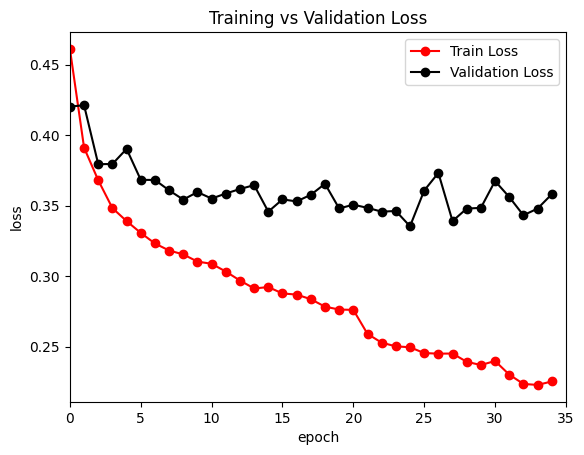

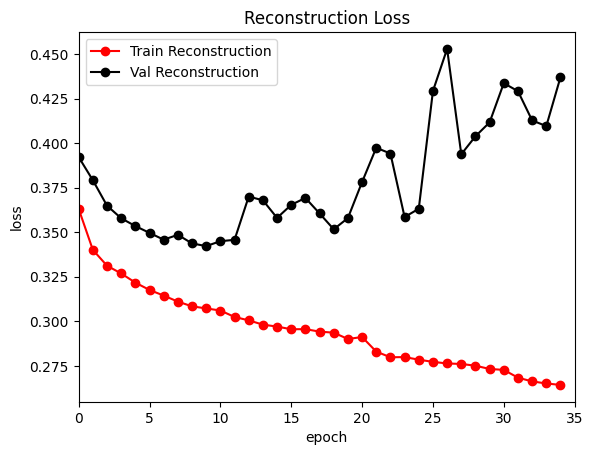

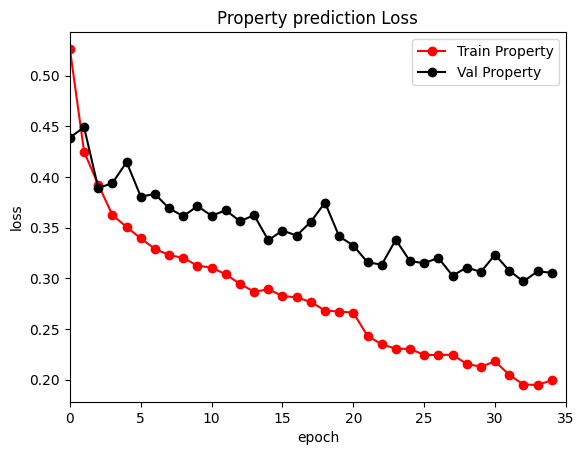

In [111]:
from google.colab import files

# Plot training history
fig, ax = plt.subplots()
# Combined losses
ax.plot(train_losses, marker='o', label='Train Loss', color='red')
ax.plot(val_losses,  marker='o', label='Validation Loss', color='black')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xlim([0,epoch+1])
ax.set_title('Training vs Validation Loss')
ax.legend()
fig.savefig('A1_AE_trainvsval_loss.png')

# Reconstruction loss
fig, ax = plt.subplots()

ax.plot(train_recon_losses,  marker='o', label='Train Reconstruction', color='red')
ax.plot(val_recon_losses,  marker='o', label='Val Reconstruction', color='black')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xlim([0,epoch+1])
ax.set_title('Reconstruction Loss')
ax.legend()
fig.savefig('A1_AE_reconstruction_loss.png')
#files.download('A2_AE_reconstruction_loss.png')

# Property prediction loss
fig, ax = plt.subplots()

ax.plot(train_prop_losses,  marker='o', label='Train Property', color='red')
ax.plot(val_prop_losses,  marker='o', label='Val Property', color='black')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xlim([0,epoch+1])
ax.set_title('Property prediction Loss')
ax.legend()
fig.savefig('A1_AE_prediction_loss.png')
#files.download('A2_AE_prediction_loss.png')




In [113]:
# Make predictions on test set
model.eval()
true_properties = []
predicted_properties = []
latent_representations = []

with torch.no_grad():
    for acsf_batch, x_global, properties_batch in test_loader:
        acsf_batch = acsf_batch.to(DEVICE)
        x_global = x_global.to(DEVICE)

        # Forward pass
        _, pred_props, latent = model(acsf_batch, x_global)

        true_properties.append(properties_batch.cpu().numpy())
        predicted_properties.append(pred_props.cpu().numpy())
        latent_representations.append(latent.cpu().numpy())

# Stack all predictions
true_properties = np.vstack(true_properties)
predicted_properties = np.vstack(predicted_properties)
latent_representations = np.vstack(latent_representations)

print(f"Test set predictions generated")
print(f"True properties shape: {true_properties.shape}")
print(f"Predicted properties shape: {predicted_properties.shape}")
print(f"Latent representations shape: {latent_representations.shape}")

Test set predictions generated
True properties shape: (1630, 1)
Predicted properties shape: (1630, 1)
Latent representations shape: (1630, 384)


In [114]:
# Calculate metrics for each property
metrics = []

true_vals = true_properties[:, 0]
pred_vals = predicted_properties[:, 0]

mse = mean_squared_error(true_vals, pred_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_vals, pred_vals)
r2 = r2_score(true_vals, pred_vals)

metrics.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2
})

metrics_df = pd.DataFrame(metrics)

print("\n" + "="*80)
print("TEST SET PERFORMANCE METRICS")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80)


TEST SET PERFORMANCE METRICS
     MSE    RMSE      MAE      R²
0.312358 0.55889 0.410412 0.67993


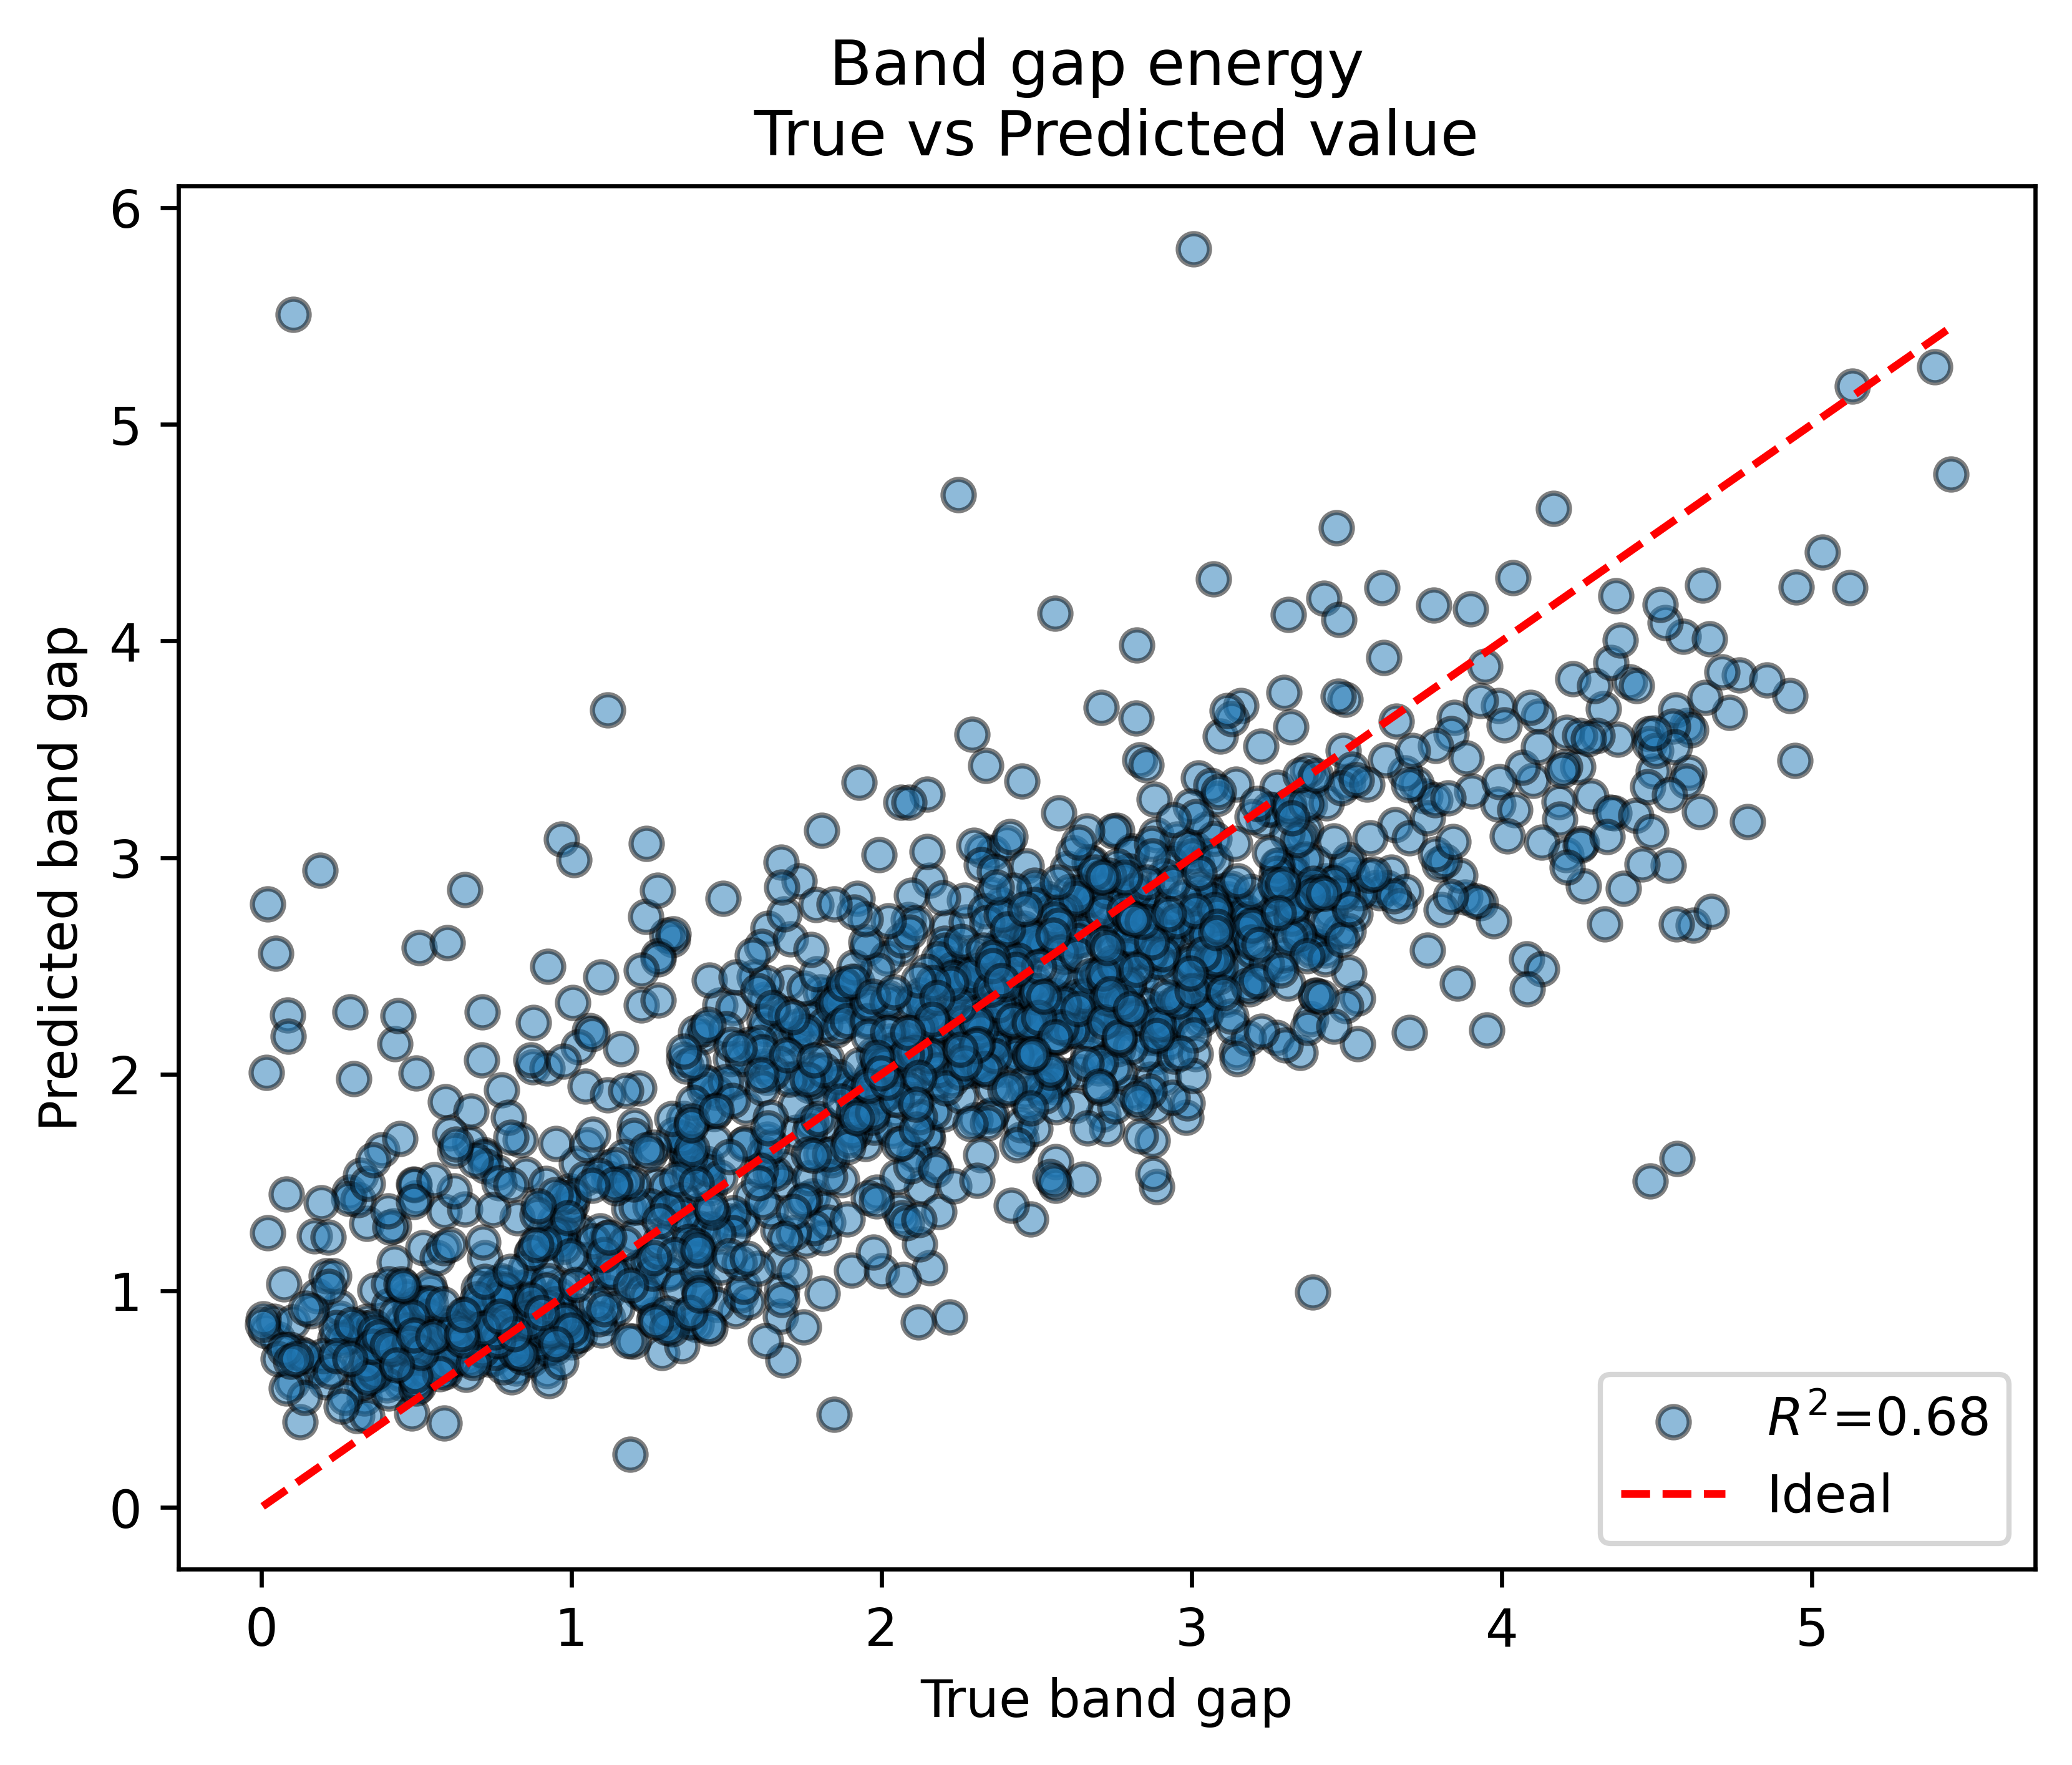

In [115]:
# Inverse transform predictions to original scale
true_vals_og = scaler_y.inverse_transform(true_vals.reshape(-1,1))
pred_vals_og = scaler_y.inverse_transform(pred_vals.reshape(-1,1))

# Plot 1: True vs Predicted energy
fig,ax = plt.subplots(dpi=600)
ax.scatter(true_vals_og, pred_vals_og, alpha=0.5, edgecolor='k', label=rf'$R^2$={r2:.2f}')
ax.plot([true_vals_og.min(), true_vals_og.max()],
         [true_vals_og.min(), true_vals_og.max()],
         'r--', label='Ideal')
ax.set_xlabel("True band gap")
ax.set_ylabel("Predicted band gap")
ax.set_title("Band gap energy \n True vs Predicted value")
ax.legend()
fig.savefig('A1_AE_bandgap.png',dpi=600)